<a href="https://colab.research.google.com/github/AnshumanAryan24/AlphaPro-SemEval2025-Task8/blob/main/notebooks/EvalPlot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Upload results file to working directory
This file will be used for grading and plotting the graphs.

In [ ]:
# Upload the file Results_1.csv containing the results on the training dataset.
from google.colab import files
uploaded = files.upload()

## Check Colab's working directory

In [ ]:
import os
print(os.listdir("/content/"))

## Install Libraries

In [ ]:
!pip install textstat

In [ ]:
!pip install databench_eval

## Importing Libraries

In [79]:
import pandas as pd

In [80]:
import spacy

In [81]:
import textstat

In [82]:
from databench_eval import Evaluator

In [83]:
from databench_eval.utils import load_qa

In [84]:
from google.colab import files

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

## Load Model and Read Input File

In [86]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

## CSV File Evaluator Function

In [87]:
def evaluate_responses(csv_filename:str, delimiter:str=",", question_col:str="Question", exp_col:str="Expected Aswer", answer_col:str="Generated Answer", print_details:bool=True) -> dict[float, dict]:
    """
    Evaluates model responses against ground truth and provides detailed comparison.

    Args:
        csv_filename (str): Path to the CSV file containing model responses
        delimiter (str): Delimiter used in the CSV file (default: ",")
        question_col (str): Column name for questions (default: "Question")
        exp_col (str): Column name containing expected (ground truth) answers (default: "Expected Answer")
        answer_col (str): Column name containing generated answers answers (default: "Generated Answer")
        print_details (bool): Indicates whether to print detailed comparison (default: True)

    Returns:
        float: Overall accuracy score
        list: List of comparison results (True/False for each item)
    """
    try:
        # Load responses from CSV
        data = pd.read_csv(csv_filename, sep=delimiter)
        responses = data[answer_col].tolist()

        # Load the QA dataset with ground truth
        qa = load_qa()

        # Create evaluator instance
        evaluator = Evaluator()

        # Compare each response with ground truth
        results = []
        for i, (response, qa_item) in enumerate(zip(responses, qa)):
            truth = qa_item["answer"]
            question = qa_item["question"]
            semantic = qa_item.get("type")

            # Compare response with ground truth
            is_correct = evaluator.compare(response, truth, semantic)
            results.append(is_correct)

            # Print detailed comparison if requested
            if print_details:
                print(f"Question {i+1}: {question}")
                print(f"Your answer: {response}")
                print(f"Ground truth: {truth}")
                print(f"Semantic type: {semantic}")
                print(f"Correct: {is_correct}")
                print("-" * 50)

        # Calculate overall accuracy
        accuracy = sum(results) / len(results) if results else 0
        print(f"Overall Accuracy: {accuracy:.2%}")

        return accuracy, results

    except Exception as e:
        print(f"Error evaluating responses: {e}")
        return 0.0, []

# Example usage:
# accuracy, results = evaluate_responses("Results_1.csv")

## Evaluator Usage

In [88]:
# # Basic usage
# accuracy, results = evaluate_responses("Results_1.csv")

# Custom usage
accuracy, results = evaluate_responses(
    csv_filename="Results_1.csv",
    delimiter=",",
    question_col="Question",
    exp_col='Expected Answer',
    answer_col="Generated Answer",
    print_details=True
)

Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

Question 1: Is the person with the highest net worth self-made?
Your answer: -
Ground truth: True
Semantic type: boolean
Correct: False
--------------------------------------------------
Question 2: Does the youngest billionaire identify as male?
Your answer: False
Ground truth: True
Semantic type: boolean
Correct: False
--------------------------------------------------
Question 3: Is the city with the most billionaires in the United States?
Your answer: False
Ground truth: True
Semantic type: boolean
Correct: False
--------------------------------------------------
Question 4: Is there a non-self-made billionaire in the top 5 ranks?
Your answer: False
Ground truth: True
Semantic type: boolean
Correct: False
--------------------------------------------------
Question 5: Does the oldest billionaire have a philanthropy score of 5?
Your answer: False
Ground truth: False
Semantic type: boolean
Correct: True
--------------------------------------------------
Question 6: What is the age of 

## Function for grading questions based on complexity (0 - 5)

In [89]:
df = pd.read_csv('Results_1.csv')

In [90]:
def grade_question_complexity(question):
    try:
        doc = nlp(question)
        num_tokens = len(doc)  # Word count
        num_clauses = sum(1 for token in doc if token.dep_ in ["ROOT", "advcl", "ccomp", "xcomp"])  # Clause count
        num_entities = len(doc.ents)  # Named entity count
        readability_score = textstat.flesch_kincaid_grade(question)  # Readability score

        if num_tokens < 7 and num_clauses == 1 and num_entities == 0 and readability_score < 5:
            return 0  # Simple fact recall
        elif num_tokens < 12 and num_clauses <= 2 and num_entities <= 1 and readability_score < 6:
            return 1  # Simple lookup
        elif num_tokens < 18 and num_clauses <= 3 and num_entities <= 2 and readability_score < 7:
            return 2  # Comparisons & simple analysis
        elif num_tokens < 25 and num_clauses <= 4 and num_entities <= 3 and readability_score < 9:
            return 3  # Historical changes & analysis
        elif num_tokens < 35 and num_clauses <= 5 and num_entities <= 4 and readability_score < 11:
            return 4  # Causal reasoning & explanations
        else:
            return 5  # Predictions & advanced reasoning
    except Exception as e:
        print(f"Error processing question '{question}': {e}")
        return -1  # Assign -1 for errors


## Grading columns, evaluating answers and saving results

In [91]:
# Apply complexity grading with error handling
df["Complexity"] = df["Question"].apply(lambda q: grade_question_complexity(str(q)))
try:
    df["Answer Match"] = results
except Exception as e:
    print(f"Error processing Answer Match column: {e}")
    df["Answer Match"] = -1  # Assign -1 for errors
else:
  # Save the processed data to a new CSV file when no errors
  output_file = "/content/graded_qa.csv"
  df[["Question", "Complexity", "Answer Match"]].to_csv(output_file, index=False)
  df['Answer Match'] = df['Answer Match'].replace(-1, 0)
  print(f"Processed file saved as: {output_file}")

Processed file saved as: /content/graded_qa.csv


In [92]:
# Average accuracy
len(df[df['Answer Match']==1])/len(df)

0.6733333333333333

### Download output file

In [93]:
files.download("/content/graded_qa.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Create Bar Plot (Complexity values are integers)

Saving graded_qa.csv to graded_qa (1).csv


<ipython-input-94-d434a007ee77>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_accuracy['Complexity'], y=avg_accuracy['Answer Match'], palette='Blues')


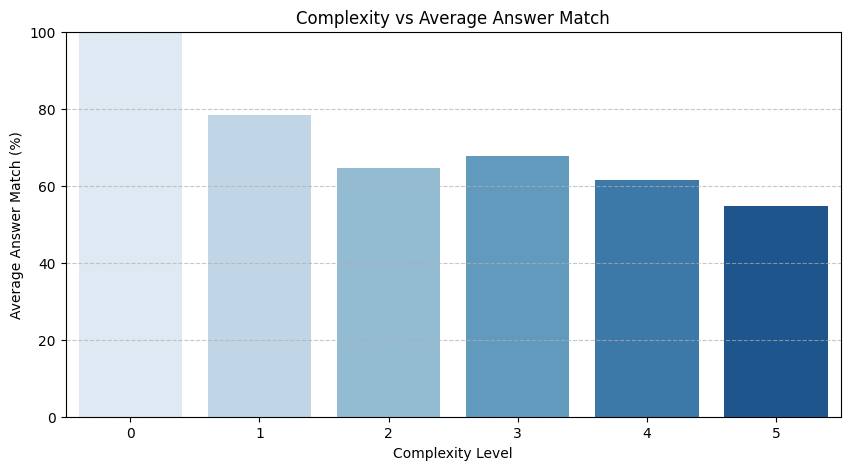

In [94]:
def upload_file() -> str:
    """
    Uploads a file manually in Google Colab and returns the filename.
    Upload the graded_qa.csv file here. This file will be needed for plotting the graphs.
    Returns:
        str: The name of the uploaded file.
    """
    uploaded = files.upload()  # Opens a file upload dialog in Colab
    return next(iter(uploaded))  # Get the uploaded file name

def read_csv_file(file_path: str) -> pd.DataFrame:
  """
  Reads a CSV file and returns a pandas DataFrame.

  Parameters:
    file_path (str): The path to the CSV file.

  Returns:
    pd.DataFrame: The loaded data.
  """
  try:
    data = pd.read_csv(file_path)
    required_columns = {'Complexity', 'Answer Match'}
    if not required_columns.issubset(data.columns):
      raise ValueError("CSV file must contain 'Complexity' and 'Answer Match' columns.")
    return data
  except Exception as e:
    print(f"Error reading CSV file: {e}")
    exit(1)

def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
  """
  Prepares the data for visualization.
  Parameters:
    data (pd.DataFrame): Raw data.

  Returns:
    pd.DataFrame: Processed data with 'Answer Match' scaled to percentage.
  """
  data = data.copy()
  data['Answer Match'] = data['Answer Match'].replace(-1, 0)
  data['Answer Match'] = data['Answer Match'].astype(float) * 100  # Convert to percentage
  return data

def plot_data(data: pd.DataFrame) -> None:
  """
  Plots a bar chart of Complexity vs Average Answer Match.

  Parameters:
      data (pd.DataFrame): Processed data.
  """
  avg_accuracy = data.groupby('Complexity')['Answer Match'].mean().reset_index()

  plt.figure(figsize=(10, 5))
  sns.barplot(x=avg_accuracy['Complexity'], y=avg_accuracy['Answer Match'], palette='Blues')

  plt.xlabel("Complexity Level")
  plt.ylabel("Average Answer Match (%)")
  plt.title("Complexity vs Average Answer Match")
  plt.ylim(0, 100)  # Since it's a percentage
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  plt.show()

def main():
  file_path = upload_file()  # Prompt user to upload file in Colab
  data = read_csv_file(file_path)
  processed_data = preprocess_data(data)
  plot_data(processed_data)

if __name__ == "__main__":
    main()


## Scatter diagram

Saving graded_qa.csv to graded_qa (3).csv


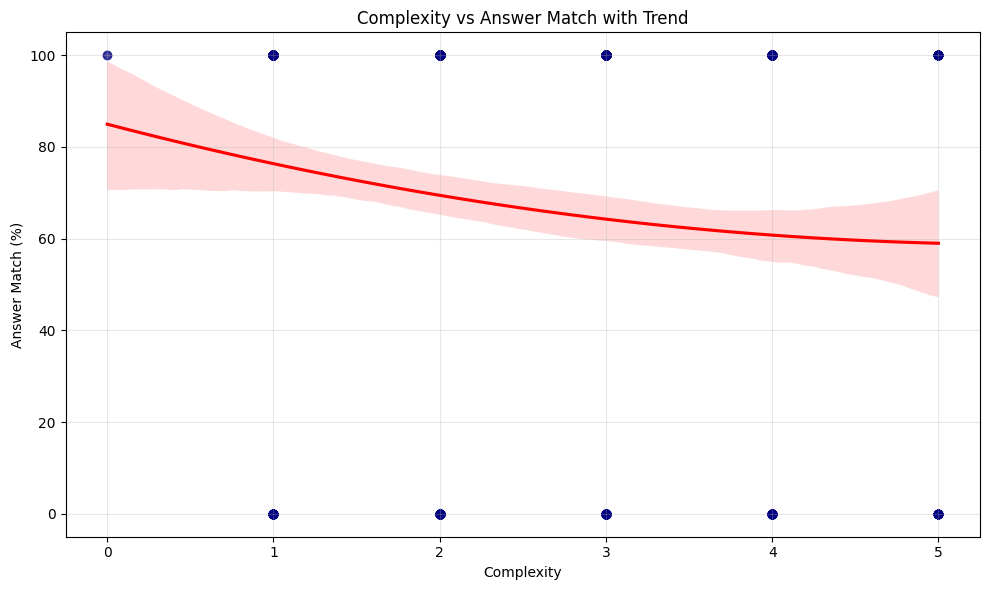

In [98]:
def upload_file() -> str:
    """
    Uploads a file manually in Google Colab and returns the filename.

    Returns:
        str: The name of the uploaded file.
    """
    uploaded = files.upload()  # Opens a file upload dialog in Colab
    return next(iter(uploaded))  # Get the uploaded file name

def read_csv_file(file_path: str) -> pd.DataFrame:
    """
    Reads a CSV file and returns a pandas DataFrame.

    Parameters:
        file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The loaded data.
    """
    try:
        data = pd.read_csv(file_path)
        required_columns = {'Complexity', 'Answer Match'}
        if not required_columns.issubset(data.columns):
            raise ValueError("CSV file must contain 'Complexity' and 'Answer Match' columns.")
        return data
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        exit(1)

def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the data for visualization.

    Parameters:
        data (pd.DataFrame): Raw data.

    Returns:
        pd.DataFrame: Processed data with 'Answer Match' scaled to percentage.
    """
    data = data.copy()
    data['Answer Match'] = data['Answer Match'].astype(float) * 100  # Convert to percentage
    return data

def plot_data(data: pd.DataFrame) -> None:
    """
    Creates a scatter plot with a trend line showing the relationship
    between Complexity and Answer Match.

    Parameters:
        data (pd.DataFrame): Processed data.
    """
    import seaborn as sns

    plt.figure(figsize=(10, 6))

    # Create scatter plot with regression line
    sns.regplot(
        x='Complexity',
        y='Answer Match',
        data=data,
        scatter_kws={'alpha': 0.5, 'color': 'navy'},
        line_kws={'color': 'red'},
        order=2  # Quadratic regression line
    )

    plt.xlabel("Complexity")
    plt.ylabel("Answer Match (%)")
    plt.title("Complexity vs Answer Match with Trend")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    file_path = upload_file()  # Prompt user to upload file in Colab
    data = read_csv_file(file_path)
    processed_data = preprocess_data(data)
    plot_data(processed_data)

if __name__ == "__main__":
    main()